## Cancer Survival Outcome Model
This dataset was taken from the METRABRIC database, which is a Canada-UK project  

Import Libraries 

In [104]:
from __future__ import absolute_import,division,print_function, unicode_literals


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Importing Sklearn packages
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf


Importing CSV file 

In [105]:
'''
nRowsToRead = 1000
df = pd.read_csv(r'METABRIC_RNA_Mutation.csv', delimiter = ',', nrows = nRowsToRead) # reading in CSV file using pandas
'''
dftrain = pd.read_csv('METABRIC_RNA_Mutation.csv')

dftrain.head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,hormone_therapy,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,stk11,bard1,mlh1,msh2,msh6,pms2,epcam,rad51c,rad51d,rad50,rb1,rbl1,rbl2,ccna1,ccnb1,cdk1,ccne1,cdk2,cdc25a,ccnd1,cdk4,cdk6,ccnd2,cdkn2a,cdkn2b,myc,cdkn1a,cdkn1b,e2f1,e2f2,e2f3,e2f4,e2f5,e2f6,e2f7,e2f8,src,jak1,jak2,stat1,stat2,stat3,stat5a,stat5b,mdm2,tp53bp1,adam10,adam17,aph1a,aph1b,arrdc1,cir1,ctbp1,ctbp2,cul1,dll1,dll3,dll4,dtx1,dtx2,dtx3,dtx4,ep300,fbxw7,hdac1,hdac2,hes1,hes5,heyl,itch,jag1,jag2,kdm5a,lfng,maml1,maml2,maml3,ncor2,ncstn,notch1,notch2,notch3,nrarp,numb,numbl,psen1,psen2,psenen,rbpj,rbpjl,rfng,snw1,spen,hes2,hes4,hes7,hey1,hey2,acvr1,acvr1b,acvr1c,acvr2a,acvr2b,acvrl1,akt1,akt1s1,akt2,apaf1,arl11,atr,aurka,bad,bcl2,bcl2l1,bmp10,bmp15,bmp2,bmp3,bmp4,bmp5,bmp6,bmp7,bmpr1a,bmpr1b,bmpr2,braf,casp10,casp3,casp6,casp7,casp8,casp9,chek1,csf1,csf1r,cxcl8,cxcr1,cxcr2,dab2,diras3,dlec1,dph1,egfr,eif4e,eif4ebp1,eif5a2,erbb2,erbb3,erbb4,fas,fgf1,fgfr1,folr1,folr2,folr3,foxo1,foxo3,gdf11,gdf2,gsk3b,hif1a,hla-g,hras,igf1,igf1r,inha,inhba,inhbc,itgav,itgb3,izumo1r,kdr,kit,kras,map2k1,map2k2,map2k3,map2k4,map2k5,map3k1,map3k3,map3k4,map3k5,mapk1,mapk12,mapk14,mapk3,mapk4,mapk6,mapk7,mapk8,mapk9,mdc1,mlst8,mmp1,mmp10,mmp11,mmp12,mmp13,mmp14,mmp15,mmp16,mmp17,mmp19,mmp2,mmp21,mmp23b,mmp24,mmp25,mmp26,mmp27,mmp28,mmp3,mmp7,mmp9,mtor,nfkb1,nfkb2,opcml,pdgfa,pdgfb,pdgfra,pdgfrb,pdpk1,peg3,pik3ca,pik3r1,pik3r2,plagl1,ptk2,rab25,rad51,raf1,rassf1,rheb,rictor,rps6,rps6ka1,rps6ka2,rps6kb1,rps6kb2,rptor,slc19a1,smad1,smad2,smad3,smad4,smad5,smad6,smad7,smad9,sptbn1,terc,tert,tgfb1,tgfb2,tgfb3,tgfbr1,tgfbr2,tgfbr3,tsc1,tsc2,vegfa,vegfb,wfdc2,wwox,zfyve9,arid1a,arid1b,cbfb,gata3,kmt2c,kmt2d,myh9,ncor1,pde4dip,ptprd,ros1,runx1,tbx3,abcb1,abcb11,abcc1,abcc10,bbc3,bmf,cyp2c8,cyp3a4,fgf2,fn1,map2,map4,mapt,nr1i2,slco1b3,tubb1,tubb4a,tubb4b,twist1,adgra2,afdn,aff2,agmo,agtr2,ahnak,ahnak2,akap9,alk,apc,arid2,arid5b,asxl1,asxl2,bap1,bcas3,birc6,cacna2d3,ccnd3,chd1,clk3,clrn2,col12a1,col22a1,col6a3,ctcf,ctnna1,ctnna3,dnah11,dnah2,dnah5,dtwd2,fam20c,fanca,fancd2,flt3,foxp1,frmd3,gh1,gldc,gpr32,gps2,hdac9,herc2,hist1h2bc,kdm3a,kdm6a,klrg1,l1cam,lama2,lamb3,large1,ldlrap1,lifr,lipi,magea8,map3k10,map3k13,men1,mtap,muc16,myo1a,myo3a,ncoa3,nek1,nf2,npnt,nr2f1,nr3c1,nras,nrg3,nt5e,or6a2,palld,pbrm1,ppp2cb,ppp2r2a,prkacg,prkce,prkcq,prkcz,prkg1,prps2,prr16,ptpn22,ptprm,rasgef1b,rpgr,ryr2,sbno1,setd1a,setd2,setdb1,sf3b1,sgcd,shank2,siah1,sik1,sik2,smarcb1,smarcc1,smarcc2,smarcd1,spaca1,stab2,stmn2,syne1,taf1,taf4b,tbl1xr1,tg,thada,thsd7a,ttyh1,ubr5,ush2a,usp9x,utrn,zfp36l1,ackr3,akr1c1,akr1c2,akr1c3,akr1c4,akt3,ar,bche,cdk8,cdkn2c,cyb5a,cyp11a1,cyp11b2,cyp17a1,cyp19a1,cyp21a2,cyp3a43,cyp3a5,cyp3a7,ddc,hes6,hsd17b1,hsd17b10,hsd17b11,hsd17b12,hsd17b13,hsd17b14,hsd17b2,hsd17b3,hsd17b4,hsd17b6,hsd17b7,hsd17b8,hsd3b1,hsd3b2,hsd3b7,mecom,met,ncoa2,nrip1,pik3r3,prkci,prkd1,ran,rdh5,sdc4,serpini1,shbg,slc29a1,sox9,spry2,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7,pik3ca_mut,tp53_mut,muc16_mut,ahnak2_mut,kmt2c_mut,syne1_mut,gata3_mut,map3k1_mut,ahnak_mut,dnah11_mut,cdh1_mut,dnah2_mut,kmt2d_mut,ush2a_mut,ryr2_mut,dnah5_mut,herc2_mut,pde4dip_mut,akap9_mut,tg_mut,birc6_mut,utrn_mut,tbx3_mut,col6a3_mut,arid1a_mut,lama2_mut,notch1_mut,cbfb_mut,ncor2_mut,col12a1_mut,col22a1_mut,pten_mut,akt1_mut,atr_mut,thada_mut,ncor1_mut,stab2_mut,myh9_mut,runx1_mut,nf1_mut,map2k4_mut,ros1_mut,lamb3_mut,arid1b_mut,erbb2_mut,sf3b1_mut,sha

In [106]:
dftrain.dtypes

patient_id                  int64
age_at_diagnosis          float64
type_of_breast_surgery     object
cancer_type                object
cancer_type_detailed       object
                           ...   
hras_mut                   object
prps2_mut                  object
smarcb1_mut                object
stmn2_mut                  object
siah1_mut                  object
Length: 693, dtype: object

In [107]:
print(f"The shape of the train data set is: {dftrain.shape}")
dftrain.info()

The shape of the train data set is: (1904, 693)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 693 entries, patient_id to siah1_mut
dtypes: float64(498), int64(5), object(190)
memory usage: 10.1+ MB


In [108]:
dftrain.drop('tumor_other_histologic_subtype', axis = 1)
dftrain.drop('cancer_type', axis = 1);

In [109]:
#Finding missing data and the percentage of it in each column
total = dftrain.isnull().sum().sort_values(ascending = False)
percent = (dftrain.isnull().sum() / dftrain.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total_NaN', 'Percent_Nan'])
missing_data.head(20)

,Total_NaN,Percent_Nan
tumor_stage,501,0.263130
3-gene_classifier_subtype,204,0.107143
primary_tumor_laterality,106,0.055672
neoplasm_histologic_grade,72,0.037815
cellularity,54,0.028361
mutation_count,45,0.023634
er_status_measured_by_ihc,30,0.015756
type_of_breast_surgery,22,0.011555
tumor_size,20,0.010504
cancer_type_detailed,15,0.007878


The data missing is only on clinical values, and none of the genetic data is missing. To best represent and visualize the missing data, I will create a seperate clinical data dataframe. 

In [110]:
dftrain.columns[:31] # tested values to find all columns representing the clinical values

Index(['patient_id', 'age_at_diagnosis', 'type_of_breast_surgery',
       'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy',
       'pam50_+_claudin-low_subtype', 'cohort', 'er_status_measured_by_ihc',
       'er_status', 'neoplasm_histologic_grade',
       'her2_status_measured_by_snp6', 'her2_status',
       'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index', 'oncotree_code',
       'overall_survival_months', 'overall_survival', 'pr_status',
       'radio_therapy', '3-gene_classifier_subtype', 'tumor_size',
       'tumor_stage', 'death_from_cancer'],
      dtype='object')

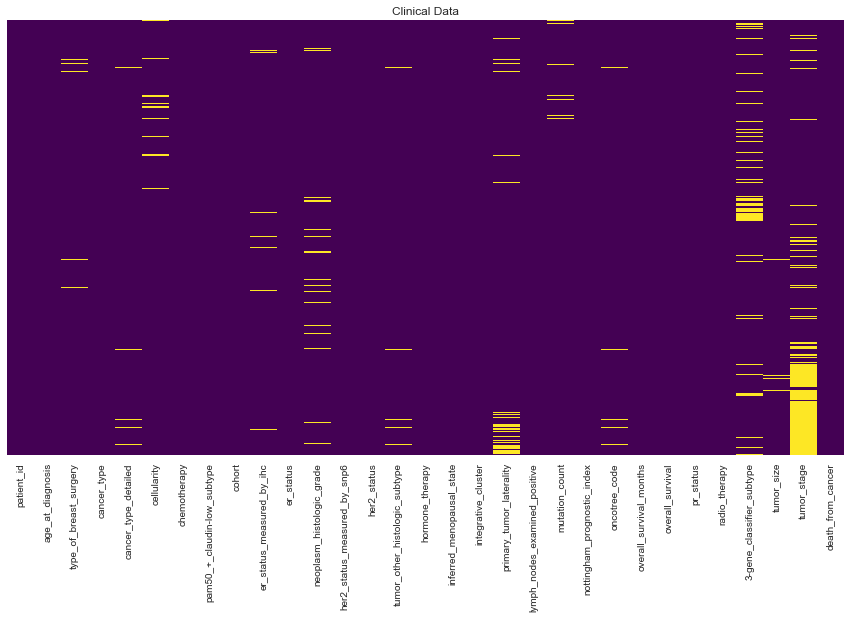

In [111]:
non_clinical_data = dftrain.columns[31:] # All non clinical features
clinical_data = dftrain.drop(non_clinical_data, axis = 1) # dropping all clinical features
# Graphing the null values of the clinical features 
fig, ax = plt.subplots(figsize = (15,8))
sns.heatmap(clinical_data.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
ax.set_title('Clinical Data')
plt.show;

Text(0.5, 1.03, 'Correlations Among Features')

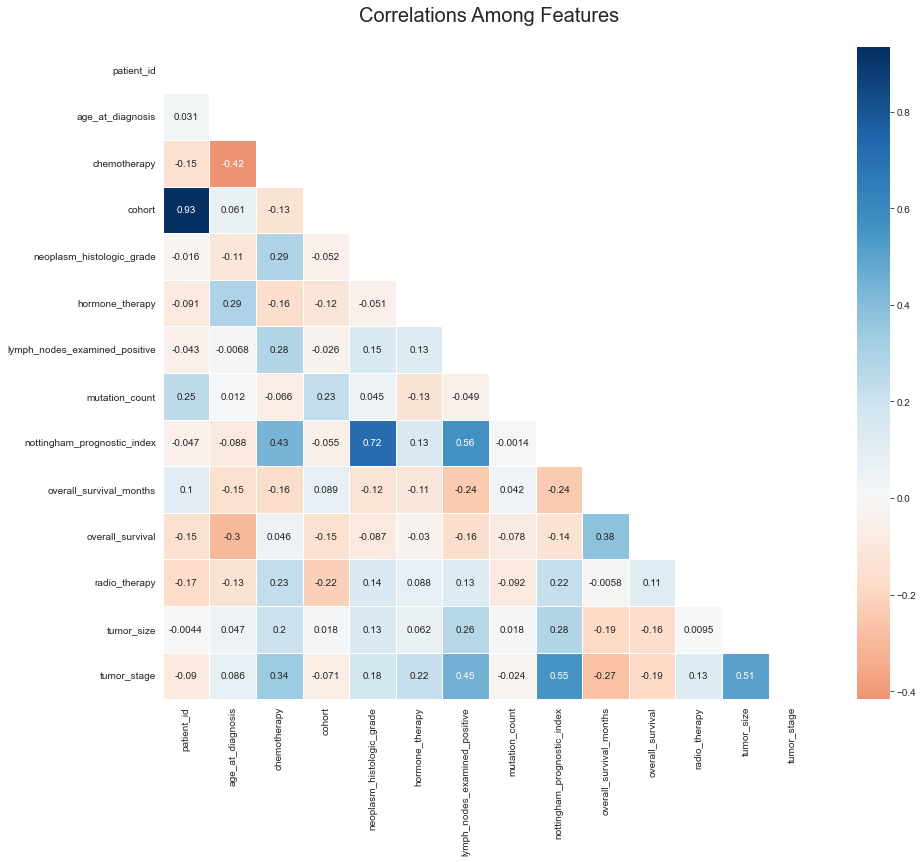

In [112]:
mask = np.zeros_like(clinical_data.corr(), dtype= bool)
mask[np.triu_indices_from(mask)] = True
sns.set_style('whitegrid')
plt.subplots(figsize = (15,12))
sns.heatmap(clinical_data.corr(), annot = True, mask= mask, cmap = 'RdBu', linewidth = 0.9, linecolor  ='white', fmt = '.2g', center = 0, square = True)
plt.title('Correlations Among Features', y = 1.03, fontsize = 20)

In [113]:
def cellularity(value):
    c = 0
    if value == 'High':
        c = 3
    elif value == 'Moderate':
        c = 2
    elif value == 'Low':
        c = 1
    return c


dftrain['cellularity_group'] = dftrain['cellularity'].map(cellularity)

In [114]:
dftrain.neoplasm_histologic_grade.fillna("N", inplace = True)
# Comparing to nottingham index due to high correlation in values 
dftrain.groupby('neoplasm_histologic_grade', as_index=False)['nottingham_prognostic_index'].mean()


,neoplasm_histologic_grade,nottingham_prognostic_index
0,1.0,2.463097
1,2.0,3.610637
2,3.0,4.815522
3,N,1.897175


In [115]:
# Function to get rid of the missing neoplasm grade values by using averages of available values
def neoplasm_grade(value):
    grade = 0
    if value < 3:
        grade = 1
    elif value >= 3 and value < 4.2:
        grade = 2
    else:
        grade = 3
    return grade

with_N = dftrain[dftrain.neoplasm_histologic_grade == 'N']
without_N = dftrain[dftrain.neoplasm_histologic_grade != 'N']

with_N['neoplasm_histologic_grade'] = with_N.nottingham_prognostic_index.apply(lambda x: neoplasm_grade(x))


In [116]:
#Finding missing data and the percentage of it in each column
total = dftrain.isnull().sum().sort_values(ascending = False)
percent = (dftrain.isnull().sum() / dftrain.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total_NaN', 'Percent_Nan'])
missing_data.head(20)

,Total_NaN,Percent_Nan
tumor_stage,501,0.263130
3-gene_classifier_subtype,204,0.107143
primary_tumor_laterality,106,0.055672
cellularity,54,0.028361
mutation_count,45,0.023634
er_status_measured_by_ihc,30,0.015756
type_of_breast_surgery,22,0.011555
tumor_size,20,0.010504
cancer_type_detailed,15,0.007878
tumor_other_histologic_subtype,15,0.007878


In [117]:
# Standardizing dataset 

def standardize(dftrain):
    num_df = dftrain[dftrain.select_dtypes(include = np.number).columns.tolist()]

    stand_scale = StandardScaler()
    std = stand_scale.fit_transform(num_df)

    std_df = pd.DataFrame(std, index = num_df.index, columns = num_df.columns)
    return std_df

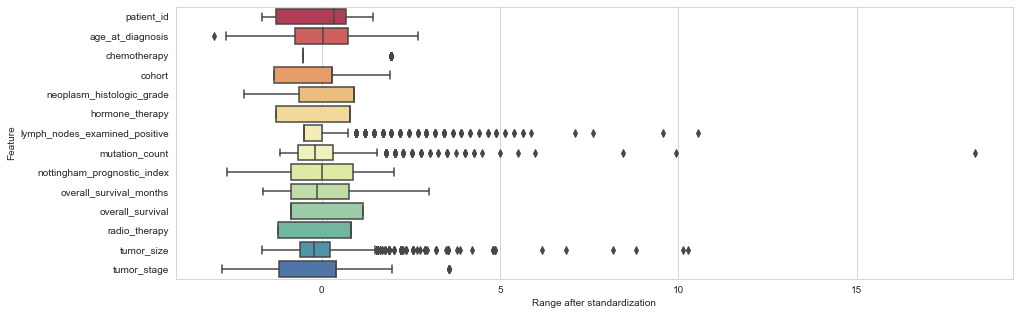

In [118]:
ax, fig = plt.subplots(figsize = (15,5))
sns.boxplot(x = 'value', y = 'variable', data = pd.melt(standardize(clinical_data)), palette = 'Spectral')
sns.set_style('whitegrid')
plt.xlabel('Range after standardization')
plt.ylabel('Feature')
plt.show();


TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

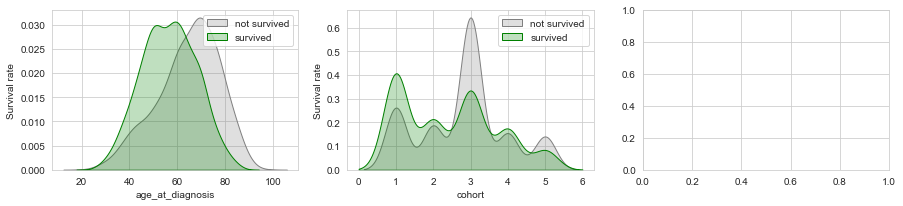

In [119]:
# Graphing numerical values to their correlation to survival rate to get some initial understandings of correlation
numerical_values = ['age_at_diagnosis', 'cohort', 'neoplasm_histologic_grade','lymph_nodes_examined_positive','mutation_count','nottingham_prognostic_index','overall_survival_months','tumor_size','tumor_stage']
a = 3 # num of rows
b = 3 # num of colums
c =1 # initializer value
fig, ax = plt.subplots(figsize = (15,10))
for i in numerical_values:
    plt.subplot(a,b,c)
    sns.kdeplot(dftrain.loc[(clinical_data['overall_survival'] == 0), i ] , color='gray',shade=True,label='not survived')
    sns.kdeplot(dftrain.loc[(clinical_data['overall_survival'] == 1), i] , color='g',shade=True, label='survived')
    plt.ylabel('Survival rate')
    plt.legend()
    c = c+1

plt.tight_layout()
plt.show()

# Initial Assumptions from clinical data
- Age of diagnosis > 70 results in lower survival rate
- Unsure of what the cohort mean but seem to correlate to lower survival in 3 and 5
- Neoplasm grade 2 and 3 are worse for survival
- Lymph nodes positive over 5 are bad for survival
- Mutation count > ~5 bad for survival
- Nottingham index > 4 bad for survival
- Tumor size > 25 bad for survival
- Tumor stage >= 2 bad for survival

While the clinical data makes up a very small portion of the overall data available, it might start to give us a good insight into those who survive and don't and will help me easy indicators to train the model in the future. 